# Data Loading and Preprocessing

In [2]:
import os
import pandas as pd
import kagglehub
import zipfile

# Step 1: Download the dataset using kagglehub
path = kagglehub.dataset_download("netflix-inc/netflix-prize-data")
print("Path to dataset files:", path)

# Step 2: Verify the downloaded files
files = os.listdir(path)
print("Files in the dataset:", files)

100%|██████████| 683M/683M [00:04<00:00, 161MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2
Files in the dataset: ['combined_data_1.txt', 'qualifying.txt', 'combined_data_4.txt', 'probe.txt', 'movie_titles.csv', 'README', 'combined_data_3.txt', 'combined_data_2.txt']


In [3]:
# Define file paths for all combined_data files
file_paths = [
    "/root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_1.txt"
    "/root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_2.txt",
    "/root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_3.txt",
    "/root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_4.txt"
]

def process_single_file(file_path):
    """
    Processes a single combined_data file and returns a DataFrame.

    Args:
        file_path (str): Path to the combined_data file.

    Returns:
        pd.DataFrame: A DataFrame containing the file's data.
    """
    rows = []
    current_movie_id = None

    # Read the file line by line
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()  # Remove extra whitespace
            if line.endswith(':'):
                # Movie ID line
                current_movie_id = int(line[:-1])  # Remove ':' and convert to int
            else:
                # CustomerID, Rating, Date line
                customer_id, rating, date = line.split(',')
                rows.append([current_movie_id, int(customer_id), int(rating), date])

    # Convert rows to a DataFrame
    df = pd.DataFrame(rows, columns=['MovieID', 'CustomerID', 'Rating', 'Date'])
    return df

def combine_files(file_paths):
    """
    Combines data from multiple combined_data files.

    Args:
        file_paths (list): List of file paths to combine.

    Returns:
        pd.DataFrame: A single combined DataFrame.
    """
    data_frames = []

    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        df = process_single_file(file_path)
        data_frames.append(df)

    # Concatenate all DataFrames
    combined_data = pd.concat(data_frames, ignore_index=True)
    return combined_data

# Combine all four combined_data files
combined_data = combine_files(file_paths)

# Display basic information about the combined data
print("Combined Data Overview:")
print(combined_data.info())
print(combined_data.head())


Processing file: /root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_1.txt
Combined Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24053764 entries, 0 to 24053763
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   MovieID     int64 
 1   CustomerID  int64 
 2   Rating      int64 
 3   Date        object
dtypes: int64(3), object(1)
memory usage: 734.1+ MB
None
   MovieID  CustomerID  Rating        Date
0        1     1488844       3  2005-09-06
1        1      822109       5  2005-05-13
2        1      885013       4  2005-10-19
3        1       30878       4  2005-12-26
4        1      823519       3  2004-05-03


# Data Features Engineering

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
import cupy as cp
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from cupyx.scipy.sparse import csr_matrix
from cupyx.scipy.sparse.linalg import svds

# Mount Google Drive for loading and saving data files
drive.mount('/content/drive', force_remount=True)
# Path to the Netflix Prize dataset
output_file = '/content/drive/My Drive/Colab Notebooks/combined_data_all.csv'

# Step 1: Preprocessing

# 1.1 Normalize Ratings
# Load the dataset with columns: MovieID, CustomerID, Rating, and Date
combined_data = pd.read_csv(output_file, names=["MovieID", "CustomerID", "Rating", "Date"], header=0, low_memory=True)
# Ensure the Rating column is numeric; convert invalid entries to NaN
combined_data['Rating'] = pd.to_numeric(combined_data['Rating'], errors='coerce')

## error checking
print(f"Total rows in combined_data: {len(combined_data)}")
print(combined_data.head())
print(combined_data.info())

# Drop rows with missing or invalid ratings
combined_data = combined_data.dropna(subset=['Rating'])

# Convert the Rating column to a GPU array using CuPy for fast computation
ratings_gpu = cp.array(combined_data['Rating'].values, dtype=cp.float32)

# Compute the global mean rating using GPU acceleration
global_mean = cp.mean(ratings_gpu).get()
# Normalize ratings by subtracting the global mean to reduce user bias
combined_data['NormalizedRating'] = combined_data['Rating'] - global_mean

# 1.2 Filter Users and Movies
# Calculate the number of ratings for each user and movie
user_counts = combined_data['CustomerID'].value_counts()
movie_counts = combined_data['MovieID'].value_counts()

# Debugging information to check filtering thresholds
print(f"Number of users: {len(user_counts)}")
print(f"Users with at least 10 ratings: {sum(user_counts >= 10)}")
print(f"Number of movies: {len(movie_counts)}")
print(f"Movies with at least 5 ratings: {sum(movie_counts >= 5)}")

# Identify low-activity users and low-rated movies
low_activity_users = user_counts[user_counts < 10].index
low_rated_movies = movie_counts[movie_counts < 5].index

# Filter users with fewer than 10 ratings
# All the movies except one has at least 10 ratings, so no further filter for movie
filtered_data = combined_data[
    combined_data['CustomerID'].isin(user_counts[user_counts >= 10].index)
]

# 1.3 Transform Dates
# Convert the Date column to a datetime format
filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])

# Calculate the number of days since the earliest rating for each row
filtered_data['DaysSinceFirstRating'] = (filtered_data['Date'] - filtered_data['Date'].min()).dt.days
# Remove the original Date column after transformation
filtered_data.drop(columns=['Date'], inplace=True)

# Step 2: Feature Engineering
# 2.1 Calculate User and Movie Mean Ratings
# Compute the mean normalized rating for each user and movie
user_mean_ratings = filtered_data.groupby('CustomerID')['NormalizedRating'].mean()
movie_mean_ratings = filtered_data.groupby('MovieID')['NormalizedRating'].mean()
# Map the mean ratings back to the dataset as new features
filtered_data['UserMeanRating'] = filtered_data['CustomerID'].map(user_mean_ratings)
filtered_data['MovieMeanRating'] = filtered_data['MovieID'].map(movie_mean_ratings)

# Ensure filtered_data is not empty after preprocessing
if filtered_data.empty:
    raise ValueError("Filtered data is empty. Please check filtering conditions or input data.")

# Debugging information to confirm data size
print(f"Filtered data size: {filtered_data.shape[0]} rows")

# Ensure that the DaysSinceFirstRating column is populated
if filtered_data[['DaysSinceFirstRating']].shape[0] == 0:
    raise ValueError("No data available for temporal bucketing.")




# 2.2 Temporal Bucketing
# Discretize DaysSinceFirstRating into 10 equal-width buckets for temporal analysis
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

filtered_data['DaysSinceFirstRatingBucket'] = discretizer.fit_transform(
    filtered_data[['DaysSinceFirstRating']]
).astype(int)

# Step 3: Splitting the Data
# Training: 80%, Validation: 10%, Testing: 10%
train_data, temp_data = train_test_split(filtered_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Step 4: Matrix Conversion
# Encode users and movies into numerical indices for efficient matrix operations
train_data['UserEncoded'] = train_data['CustomerID'].astype('category').cat.codes
train_data['MovieEncoded'] = train_data['MovieID'].astype('category').cat.codes

# Apply same encoding for validation and test sets
val_data['UserEncoded'] = val_data['CustomerID'].astype('category').cat.codes
val_data['MovieEncoded'] = val_data['MovieID'].astype('category').cat.codes
test_data['UserEncoded'] = test_data['CustomerID'].astype('category').cat.codes
test_data['MovieEncoded'] = test_data['MovieID'].astype('category').cat.codes


# 4.1 User-Movie Interaction Matrix
# Convert data into arrays for matrix factorization
# Convert data to CuPy arrays
customer_ids = cp.array(filtered_data['CustomerID'].astype('category').cat.codes)
movie_ids = cp.array(filtered_data['MovieID'].astype('category').cat.codes)
normalized_ratings = cp.array(filtered_data['NormalizedRating'])

# Create a sparse interaction matrix
# Convert to scalar integers using .item()
num_customers = customer_ids.max().item() + 1
num_movies = movie_ids.max().item() + 1

# Create a sparse matrix for interactions
interaction_matrix_gpu = csr_matrix((normalized_ratings, (customer_ids, movie_ids)),
                                    shape=(customer_ids.max() + 1, movie_ids.max() + 1))

# 4.2 Perform SVD (Singular Value Decomposition)
# Decompose the interaction matrix into latent features for users and movies
# Perform SVD with CuPy
u, s, vt = svds(interaction_matrix_gpu, k=3)  # Top 10 latent features

# Convert latent features to NumPy arrays for further processing
latent_features = cp.asnumpy(u)  # Use u for user latent features
latent_features_df = pd.DataFrame(latent_features)# Create DataFrames for latent features
latent_features_df['CustomerID'] = filtered_data['CustomerID'].astype('category').cat.categories

movie_latent_features = cp.asnumpy(vt.T)  # Use vt for Movie latent features
movie_latent_features_df = pd.DataFrame(movie_latent_features)
movie_latent_features_df['MovieID'] = filtered_data['MovieID'].astype('category').cat.categories

# Reset the index for merging
latent_features_df.reset_index(drop=True, inplace=True)

# Merge latent features back into training, validation, and testing datasets
train_data = train_data.merge(latent_features_df, on='CustomerID', how='left')
val_data = val_data.merge(latent_features_df, on='CustomerID', how='left')
test_data = test_data.merge(latent_features_df, on='CustomerID', how='left')
train_data = train_data.merge(movie_latent_features_df, on='MovieID', how='left')
val_data = val_data.merge(movie_latent_features_df, on='MovieID', how='left')
test_data = test_data.merge(movie_latent_features_df, on='MovieID', how='left')

# Fill missing latent feature values with 0
train_data.fillna(0, inplace=True)
val_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)


# Reapply UserEncoded and MovieEncoded after merging
train_data['UserEncoded'] = train_data['CustomerID'].astype('category').cat.codes
train_data['MovieEncoded'] = train_data['MovieID'].astype('category').cat.codes

val_data['UserEncoded'] = val_data['CustomerID'].astype('category').cat.codes
val_data['MovieEncoded'] = val_data['MovieID'].astype('category').cat.codes

test_data['UserEncoded'] = test_data['CustomerID'].astype('category').cat.codes
test_data['MovieEncoded'] = test_data['MovieID'].astype('category').cat.codes

# Define latent feature columns
"""
Index(['MovieID', 'CustomerID', 'Rating', 'NormalizedRating',
       'DaysSinceFirstRating', 'UserMeanRating', 'MovieMeanRating',
       'DaysSinceFirstRatingBucket', '0_x', '1_x', '0_y', '1_y', 'UserEncoded',
       'MovieEncoded'],
      dtype='object')
train data columns above
"""
latent_feature_cols = ['0_x', '1_x', '2_x', '0_y', '1_y', '2_y']


# Step 5: Define Features and Targets
X_train = train_data[['UserEncoded', 'MovieEncoded', 'DaysSinceFirstRating',
                      'UserMeanRating', 'MovieMeanRating', 'DaysSinceFirstRatingBucket'] + latent_feature_cols]
X_val = val_data[['UserEncoded', 'MovieEncoded', 'DaysSinceFirstRating',
                  'UserMeanRating', 'MovieMeanRating', 'DaysSinceFirstRatingBucket'] + latent_feature_cols]
X_test = test_data[['UserEncoded', 'MovieEncoded', 'DaysSinceFirstRating',
                    'UserMeanRating', 'MovieMeanRating', 'DaysSinceFirstRatingBucket'] + latent_feature_cols]
# 5.1: Create interaction terms
for i, user_col in enumerate(latent_feature_cols[:2]):  # User latent features are the first two columns
    for j, movie_col in enumerate(latent_feature_cols[2:]):  # Movie latent features are the last two columns
        X_train[f'interaction_{i}_{j}'] = X_train[user_col] * X_train[movie_col]
        X_val[f'interaction_{i}_{j}'] = X_val[user_col] * X_val[movie_col]
        X_test[f'interaction_{i}_{j}'] = X_test[user_col] * X_test[movie_col]


# Extract the response variables.
y_train = train_data['NormalizedRating']
y_val = val_data['NormalizedRating']
y_test = test_data['NormalizedRating']

# Fill missing values with 0
X_train.fillna(0, inplace=True)
X_val.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Here, it need google drive at least 100 GB storage
# Once stored, no longer need to redo the above data feature engineering part once offline
X_train.to_csv('/content/drive/My Drive/Colab Notebooks/X_train.csv', index=False)
X_val.to_csv('/content/drive/My Drive/Colab Notebooks/X_val.csv', index=False)
X_test.to_csv('/content/drive/My Drive/Colab Notebooks/X_test.csv', index=False)

y_train.to_csv('/content/drive/My Drive/Colab Notebooks/y_train.csv', index=False)
y_val.to_csv('/content/drive/My Drive/Colab Notebooks/y_val.csv', index=False)
y_test.to_csv('/content/drive/My Drive/Colab Notebooks/y_test.csv', index=False)
print("Datasets saved successfully!")


Mounted at /content/drive
Total rows in combined_data: 24053764
   MovieID  CustomerID  Rating        Date
0        1     1488844       3  2005-09-06
1        1      822109       5  2005-05-13
2        1      885013       4  2005-10-19
3        1       30878       4  2005-12-26
4        1      823519       3  2004-05-03
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24053764 entries, 0 to 24053763
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   MovieID     int64 
 1   CustomerID  int64 
 2   Rating      int64 
 3   Date        object
dtypes: int64(3), object(1)
memory usage: 734.1+ MB
None
Number of users: 470758
Users with at least 10 ratings: 340955
Number of movies: 4499
Movies with at least 5 ratings: 4499


<ipython-input-2-8dd614b2114a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])
<ipython-input-2-8dd614b2114a>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['DaysSinceFirstRating'] = (filtered_data['Date'] - filtered_data['Date'].min()).dt.days
<ipython-input-2-8dd614b2114a>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

Filtered data size: 23446770 rows


<ipython-input-2-8dd614b2114a>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['DaysSinceFirstRatingBucket'] = discretizer.fit_transform(
<ipython-input-2-8dd614b2114a>:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'interaction_{i}_{j}'] = X_train[user_col] * X_train[movie_col]
<ipython-input-2-8dd614b2114a>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Datasets saved successfully!


## Load the partition data.

In [2]:
# Load the datasets from Google Drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
import cupy as cp
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from cupyx.scipy.sparse import csr_matrix
from cupyx.scipy.sparse.linalg import svds
# Reload the data back once offline.
drive.mount('/content/drive', force_remount=True) #Give colab access to gdrive content.
X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_train.csv')
X_val = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_val.csv')
X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_test.csv')

y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_train.csv')
y_val = pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_val.csv')
y_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_test.csv')

print("Datasets loaded successfully!")

Mounted at /content/drive
Datasets loaded successfully!


# XGboost Model

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [12]:
# Initialize XGBoost Regressor
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Regression objective
    eval_metric='rmse',           # Evaluation metric
    use_label_encoder=False,      # Avoid label encoding warnings
    tree_method='gpu_hist',       # Use GPU for training if available
    gpu_id=0
)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],      # Number of trees
    'max_depth': [3, 5, 7, 9],                # Maximum tree depth
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'subsample': [0.6, 0.8, 1.0],             # Fraction of samples used per tree
    'colsample_bytree': [0.6, 0.8, 1.0],      # Fraction of features used per tree
    'min_child_weight': [1, 3, 5],            # Minimum sum of weights for a leaf
    'gamma': [0, 0.1, 0.2, 0.5],              # Minimum loss reduction
}

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,               # Number of random parameter combinations to try
    cv=3,                    # Cross-validation folds
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,               # Use all available CPUs
    random_state=42
)

# Fit the model to training data
random_search.fit(X_train, y_train)

# Best parameters from tuning
print("Best parameters:", random_search.best_params_)

# Best model
best_model = random_search.best_estimator_

# Predict on validation and test data
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Evaluate performance
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:08:30] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:08:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:08:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } a

Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:09:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:09:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Validation RMSE: 0.8658
Test RMSE: 0.8657


In [11]:
import joblib
import matplotlib.pyplot as plt
best_model = joblib.load('/content/drive/My Drive/Colab Notebooks/best_xgboost_model.pkl')
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(test_rmse)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:24:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


0.8656562803833052


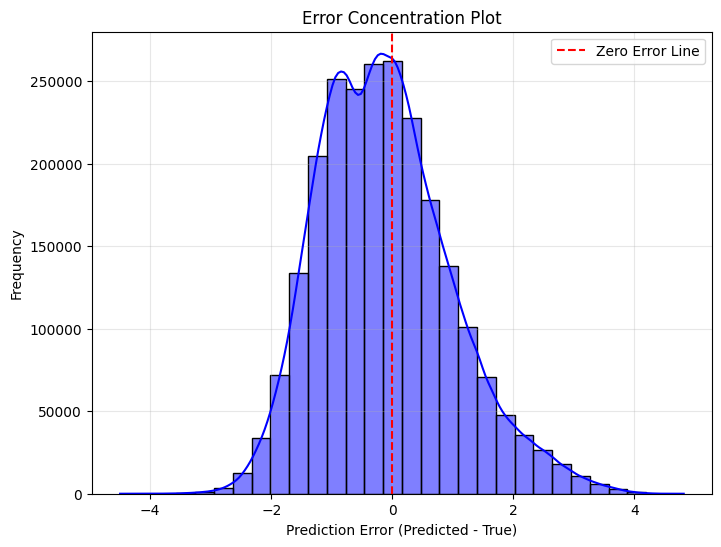

In [23]:
errors = y_test_pred - y_test

# Plotting Error Concentration
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True, color="blue")  # Histogram with kernel density estimate
plt.axvline(0, color='red', linestyle='--', label="Zero Error Line")  # Zero error line
plt.title("Error Concentration Plot")
plt.xlabel("Prediction Error (Predicted - True)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Training RMSE: 0.8511


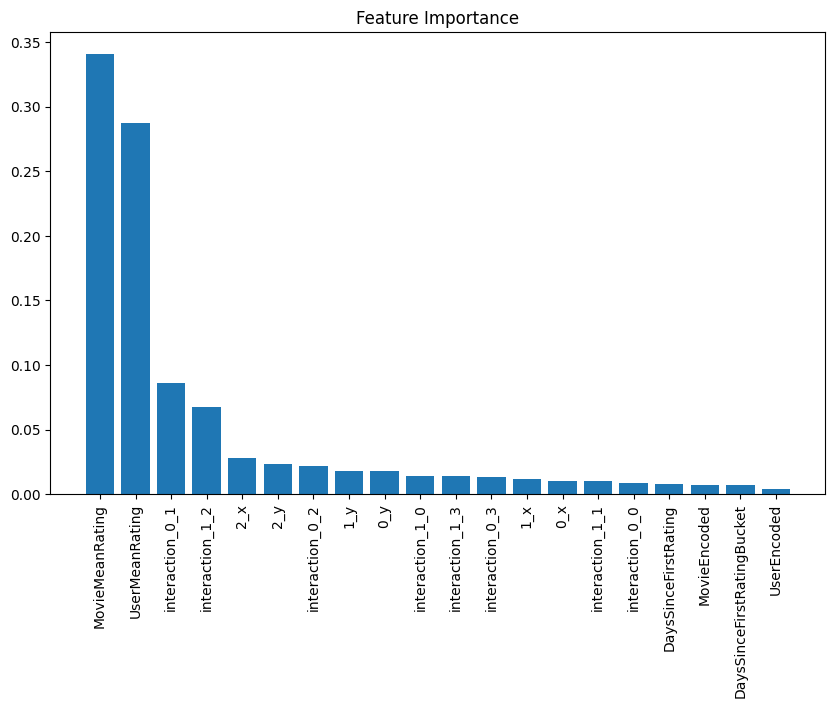

In [19]:

#Report the training RMSE for best model
y_train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {train_rmse:.4f}")


# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order

plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_importance)), X_train.columns[sorted_idx], rotation=90)
plt.title("Feature Importance")
plt.show()

Save the Best Model

In [14]:
import joblib

# Save the model
joblib.dump(best_model, '/content/drive/My Drive/Colab Notebooks/best_xgboost_model.pkl')

# Load the model (if needed later)
loaded_model = joblib.load('/content/drive/My Drive/Colab Notebooks/best_xgboost_model.pkl')

Save to pdf

In [24]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

notebookpath = '/content/drive/My Drive/Colab Notebooks/develop_1.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,192 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [32.9 kB]
Get:11 https://r2u.stat.illinois.ed

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>